Import Modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from numpy.linalg import inv
from sklearn.pipeline import Pipeline

Load & Prepare "Breast Cancer" Dataset

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")
df = pd.concat([X, y], axis=1)

df.to_csv("../data/breast_cancer.csv", index=False)
display(df.head())

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Train-test Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
y_train.value_counts().sort_index()

target
0    169
1    286
Name: count, dtype: int64

In [5]:
y_test.value_counts().sort_index()

target
0    43
1    71
Name: count, dtype: int64

Standardization

In [6]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

Define Distance Metrics

In [7]:
cov = np.cov(X_train_std, rowvar=False)
VI = inv(cov)

distance_metrics = {
'euclidean': 'euclidean',
'manhattan': 'manhattan',
'chebyshev': 'chebyshev',
'minkowski_p3': {'metric': 'minkowski', 'p': 3},
'minkowski_p4': {'metric': 'minkowski', 'p': 4},
'cosine': 'cosine',
'mahalanobis': {'metric': 'mahalanobis', 'VI': VI}
}

Evaluate KNN across Metrics

In [8]:
k_values = range(1, 31)
results = {}

for name, metric_info in distance_metrics.items():
    acc_list = []
    for k in k_values:
        if name.startswith('minkowski'):
            knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=metric_info['p'])
        elif name == 'mahalanobis':
            knn = KNeighborsClassifier(n_neighbors=k, metric='mahalanobis', metric_params={'VI': VI})
        else:
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric_info)

        knn.fit(X_train_std, y_train)
        y_pred = knn.predict(X_test_std)
        acc_list.append(accuracy_score(y_test, y_pred))
    results[name] = acc_list

Individual Accuracy Curves

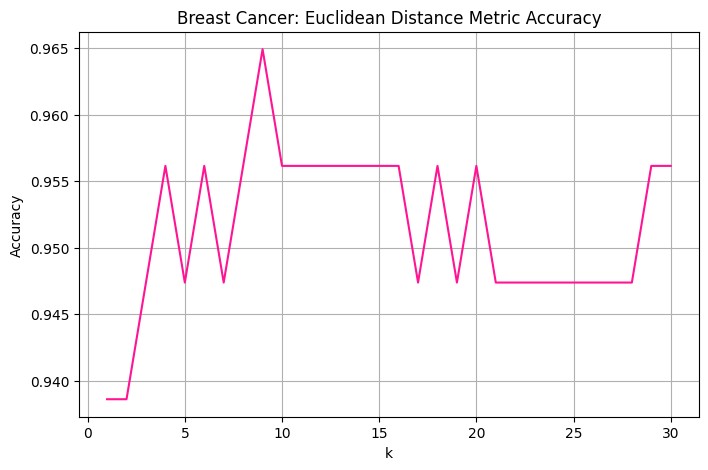

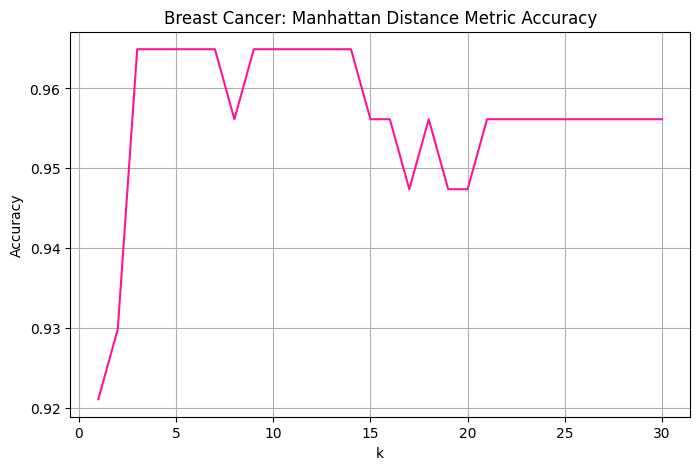

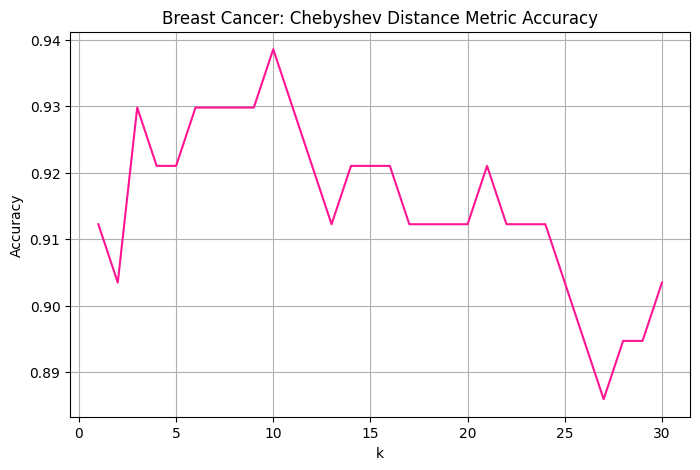

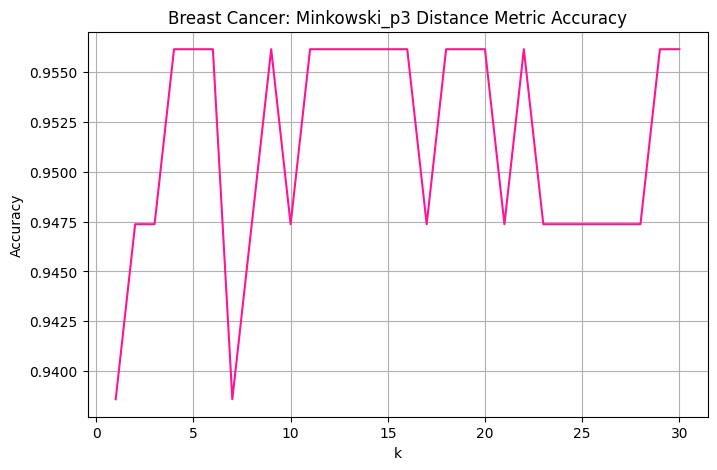

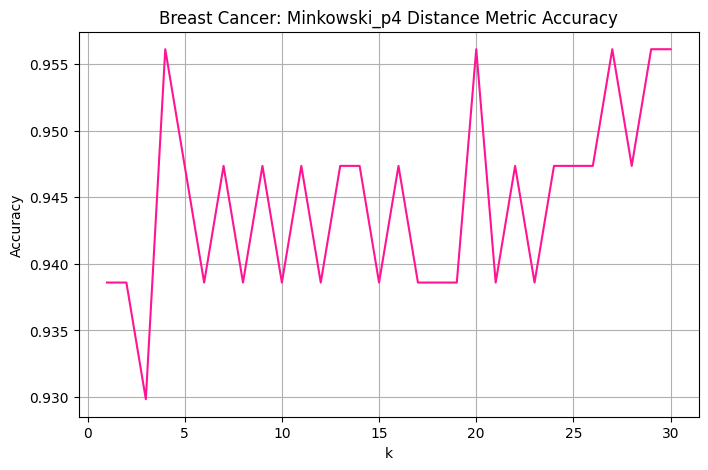

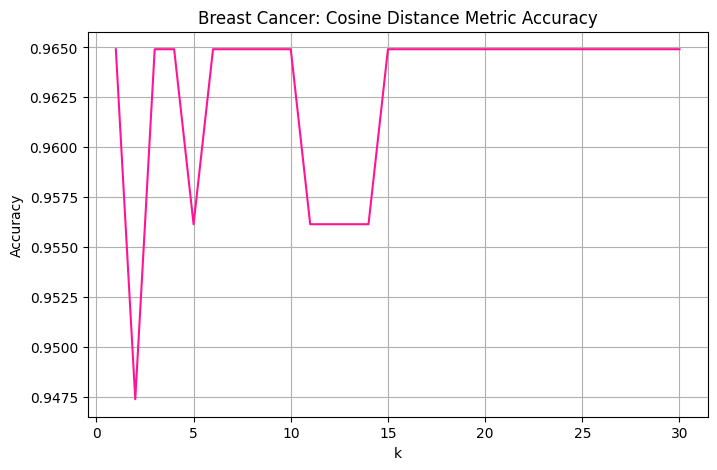

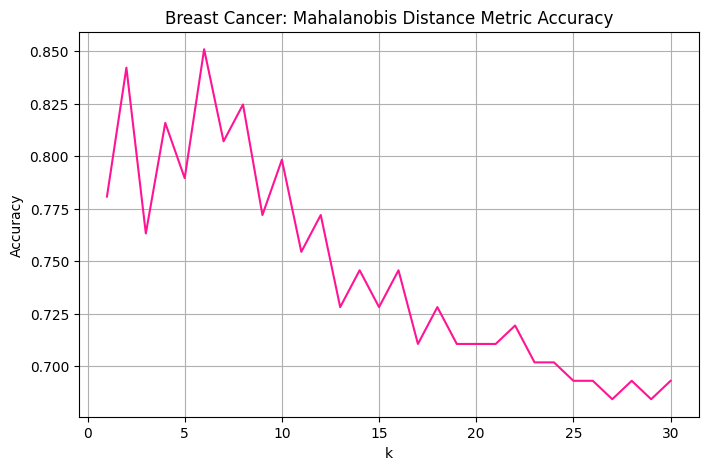

In [9]:
for name, acc in results.items():
    plt.figure(figsize=(8,5))
    plt.plot(k_values, acc, color= '#FF1493')
    plt.xlabel("k")
    plt.ylabel("Accuracy")
    plt.title(f"Breast Cancer: {name.capitalize()} Distance Metric Accuracy")
    plt.grid(True)
    plt.savefig(f"../Results/Cancer_Results/Plots/Accuracy_Curves/cancer_{name}_curve.png", dpi=300, bbox_inches='tight')
    plt.show()

Cross Validation With Pipeline

In [10]:
def make_pipeline(metric, p=None):
    if metric == 'minkowski':
        return Pipeline([
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier(metric='minkowski', p=p))
        ])
    elif metric == 'mahalanobis':
        return Pipeline([
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier(metric='mahalanobis', metric_params={'VI': VI}))
        ])
    else:
        return Pipeline([
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier(metric=metric))
        ])

cv_results = {}
for name, metric_info in distance_metrics.items():
    cv_scores = []
    for k in k_values:
        if name.startswith('minkowski'):
            pipe = make_pipeline('minkowski', p=metric_info['p'])
        else:
            pipe = make_pipeline(name)

        pipe.named_steps['knn'].n_neighbors = k
        scores = cross_val_score(pipe, X, y, cv=5)
        cv_scores.append(np.mean(scores))
    cv_results[name] = cv_scores

Individual Cross Validation Plots

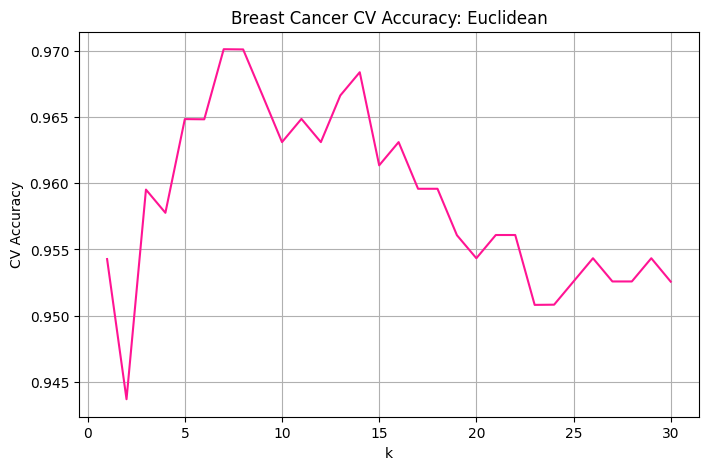

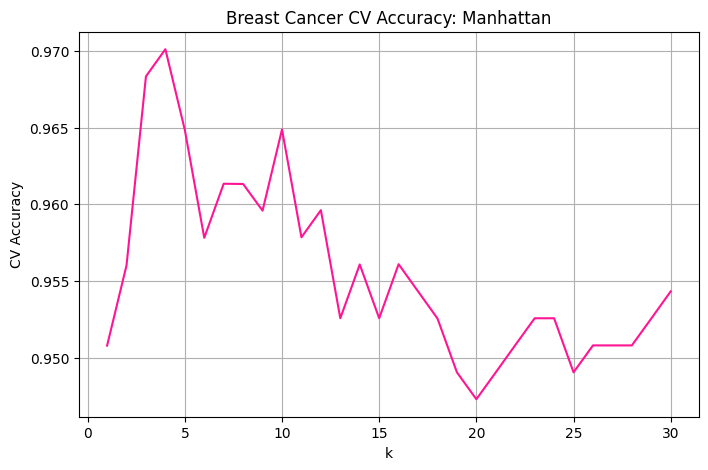

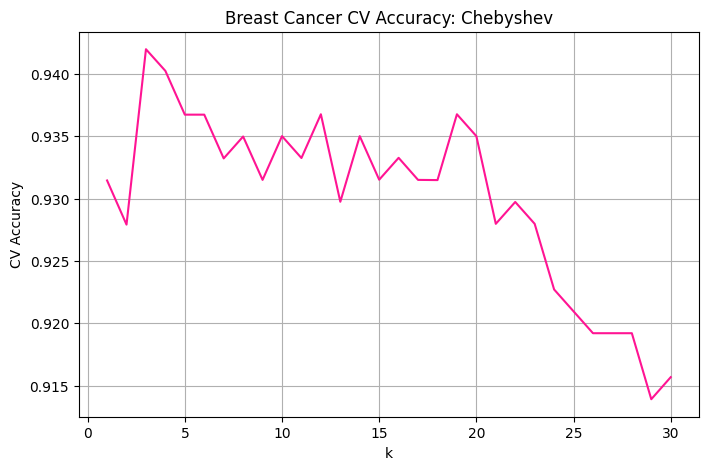

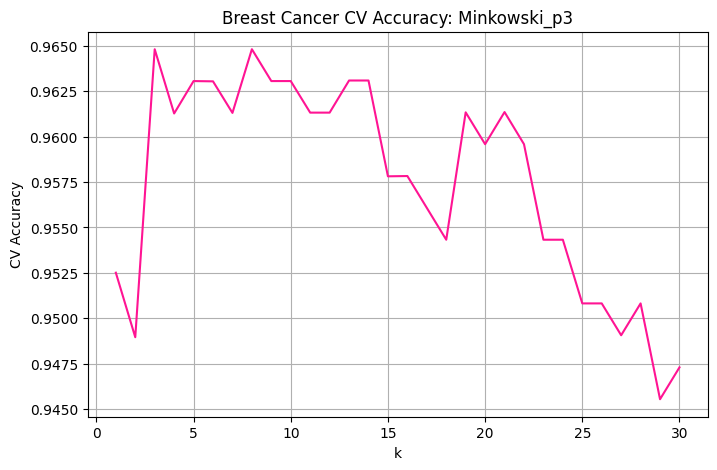

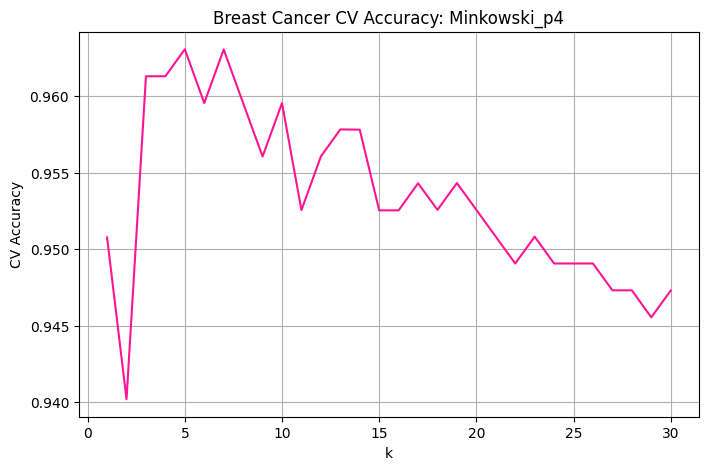

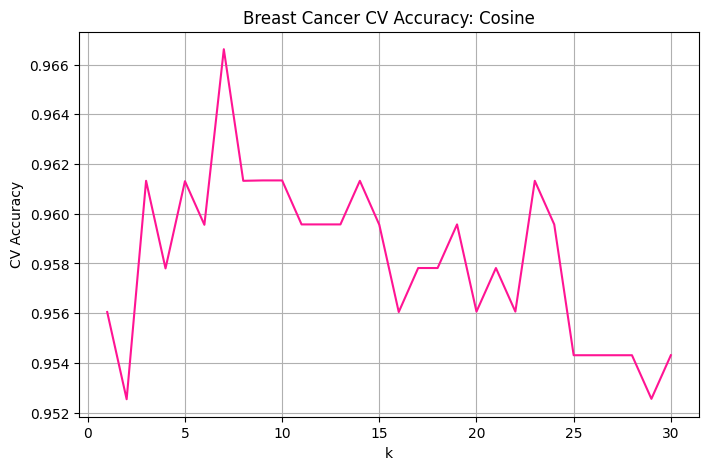

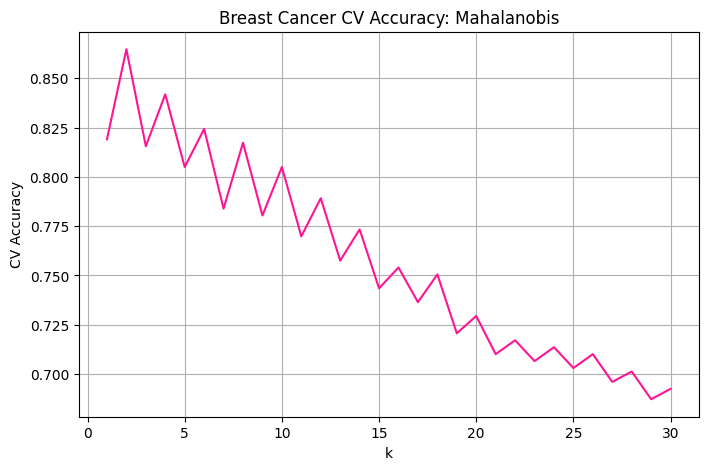

In [11]:
for name, scores in cv_results.items():
    plt.figure(figsize=(8,5))
    plt.plot(k_values, scores, color='#FF1493')
    plt.xlabel("k")
    plt.ylabel("CV Accuracy")
    plt.title(f"Breast Cancer CV Accuracy: {name.capitalize()}")
    plt.grid(True)
    plt.savefig(f"../Results/Cancer_Results/Plots/Cross_Validation_Plots/cancer_cv_{name}.png", dpi=300, bbox_inches='tight')
    plt.show()

Confusion Matrices (CV-Selected k, Initial Test Split)

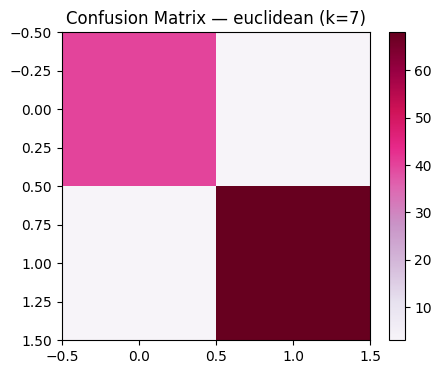

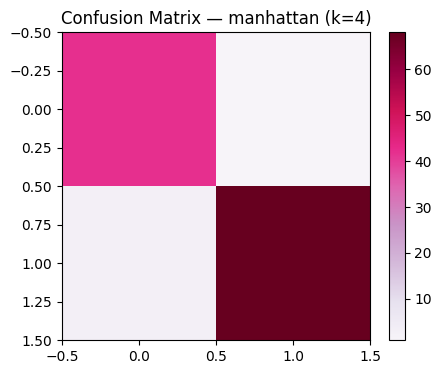

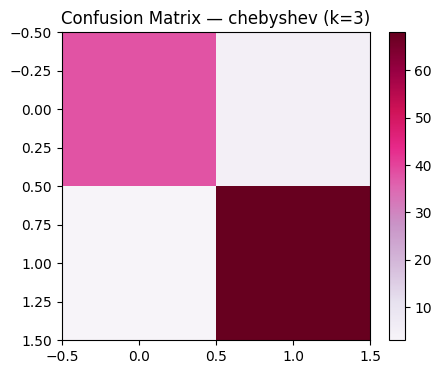

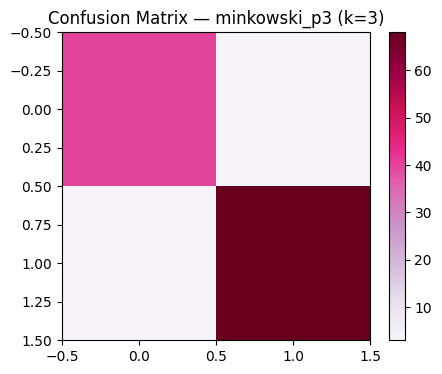

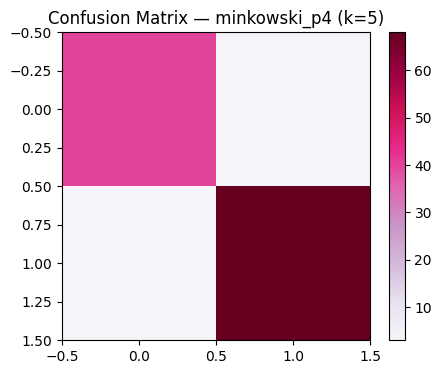

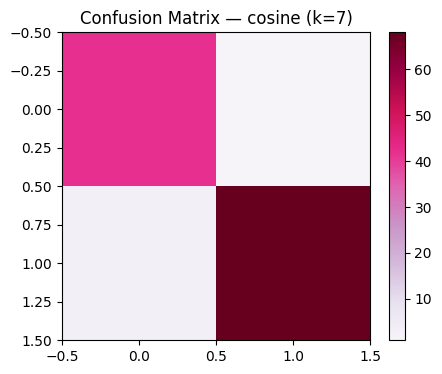

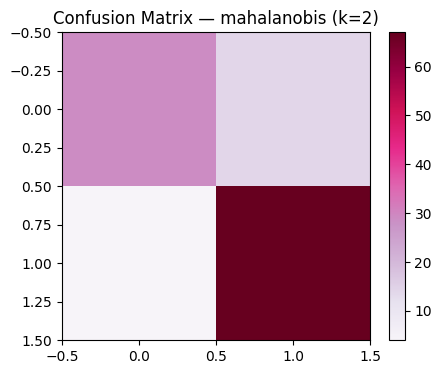

In [12]:
best_k = {name: np.argmax(scores) + 1 for name, scores in cv_results.items()}
conf_mats = {}

for name, k_sel in best_k.items():
    metric_info = distance_metrics[name]

    if name.startswith('minkowski'):
        knn = KNeighborsClassifier(n_neighbors=k_sel, metric='minkowski', p=metric_info['p'])
    elif name == 'mahalanobis':
        knn = KNeighborsClassifier(n_neighbors=k_sel, metric='mahalanobis', metric_params={'VI': VI})
    else:
        knn = KNeighborsClassifier(n_neighbors=k_sel, metric=metric_info)

    knn.fit(X_train_std, y_train)
    preds = knn.predict(X_test_std)
    cm = confusion_matrix(y_test, preds)
    conf_mats[name] = cm
    
    plt.figure(figsize=(5,4))
    plt.imshow(cm, cmap="PuRd")
    plt.title(f"Confusion Matrix — {name} (k={k_sel})")
    plt.colorbar()
    plt.savefig(f"../Results/Cancer_Results/Plots/Confusion_Matrices/cancer_confusion_{name}.png", dpi=300)
    plt.show()

Classification Report For Each Distant Metrics (CV-Selected k, Initial Test Split)

In [13]:
for name, k_sel in best_k.items():
    metric_info = distance_metrics[name]
    if name.startswith('minkowski'):
        knn = KNeighborsClassifier(n_neighbors=k_sel, metric='minkowski', p=metric_info['p'])
    elif name == 'mahalanobis':
        knn = KNeighborsClassifier(n_neighbors=k_sel, metric='mahalanobis', metric_params={'VI': VI})
    else:
        knn = KNeighborsClassifier(n_neighbors=k_sel, metric=metric_info)
    
    knn.fit(X_train_std, y_train)
    preds = knn.predict(X_test_std)
    report = classification_report(y_test, preds, output_dict=True)
    df_rep = pd.DataFrame(report).transpose()
    df_rep.to_csv(f'../Results/Cancer_Results/Classification_Reports/{name}_classification_report.csv')
    print(f"Classification Report for {name} (k={k_sel}):")
    display(df_rep)


Classification Report for euclidean (k=7):


,precision,recall,f1-score,support
0,0.930233,0.930233,0.930233,43.000000
1,0.957746,0.957746,0.957746,71.000000
accuracy,0.947368,0.947368,0.947368,0.947368
macro avg,0.943990,0.943990,0.943990,114.000000
weighted avg,0.947368,0.947368,0.947368,114.000000


Classification Report for manhattan (k=4):


,precision,recall,f1-score,support
0,0.933333,0.976744,0.954545,43.000000
1,0.985507,0.957746,0.971429,71.000000
accuracy,0.964912,0.964912,0.964912,0.964912
macro avg,0.959420,0.967245,0.962987,114.000000
weighted avg,0.965828,0.964912,0.965060,114.000000


Classification Report for chebyshev (k=3):


,precision,recall,f1-score,support
0,0.926829,0.883721,0.904762,43.000000
1,0.931507,0.957746,0.944444,71.000000
accuracy,0.929825,0.929825,0.929825,0.929825
macro avg,0.929168,0.920734,0.924603,114.000000
weighted avg,0.929742,0.929825,0.929476,114.000000


Classification Report for minkowski_p3 (k=3):


,precision,recall,f1-score,support
0,0.930233,0.930233,0.930233,43.000000
1,0.957746,0.957746,0.957746,71.000000
accuracy,0.947368,0.947368,0.947368,0.947368
macro avg,0.943990,0.943990,0.943990,114.000000
weighted avg,0.947368,0.947368,0.947368,114.000000


Classification Report for minkowski_p4 (k=5):


,precision,recall,f1-score,support
0,0.930233,0.930233,0.930233,43.000000
1,0.957746,0.957746,0.957746,71.000000
accuracy,0.947368,0.947368,0.947368,0.947368
macro avg,0.943990,0.943990,0.943990,114.000000
weighted avg,0.947368,0.947368,0.947368,114.000000


Classification Report for cosine (k=7):


,precision,recall,f1-score,support
0,0.933333,0.976744,0.954545,43.000000
1,0.985507,0.957746,0.971429,71.000000
accuracy,0.964912,0.964912,0.964912,0.964912
macro avg,0.959420,0.967245,0.962987,114.000000
weighted avg,0.965828,0.964912,0.965060,114.000000


Classification Report for mahalanobis (k=2):


,precision,recall,f1-score,support
0,0.878788,0.674419,0.763158,43.000000
1,0.827160,0.943662,0.881579,71.000000
accuracy,0.842105,0.842105,0.842105,0.842105
macro avg,0.852974,0.809040,0.822368,114.000000
weighted avg,0.846634,0.842105,0.836911,114.000000


Results Summary

In [14]:
best_acc_cv = {name: np.max(scores) for name, scores in cv_results.items()}
summary_df = pd.DataFrame({'Best CV Accuracy': best_acc_cv, 'Best k (CV)': best_k})
display(summary_df)
summary_df.to_csv('../Results/Cancer_Results/Cancer_Summary.csv')

,Best CV Accuracy,Best k (CV)
euclidean,0.970129,7
manhattan,0.970113,4
chebyshev,0.941981,3
minkowski_p3,0.964819,3
minkowski_p4,0.963080,5
cosine,0.966620,7
mahalanobis,0.864695,2
